# Import Statements

In [346]:
# IMPORT STATEMENTS

#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import ast

# Import Snowflake modules
from snowflake.snowpark import Session
#from pyspark.sql.functions import year
import snowflake.snowpark.functions as F
# import snowflake.snowpark.types as T

# import matplotlib and seaborn to plot charts and graphs
import matplotlib.pyplot as plt
import seaborn as sns

# to split training and testing data
from sklearn.model_selection import train_test_split

# DATA PREPARATION
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# MODEL BUILDING
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn. ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR

# MODEL EVALUATION & IMPROVEMENT
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# to export model
import joblib

# Functions

In [347]:
def model_performance(model):
    print('the training root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_train_scaled), y_train)))
    print('the testing root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_test_scaled), y_test)))

    print()

    #training mse
    train_mse = mean_squared_error(model.predict(X_train_scaled), y_train)
    print('the training mean squared error is: ', train_mse)
    #testing mse
    test_mse = mean_squared_error(model.predict(X_test_scaled), y_test)
    print('the testing mean squared error is: ', test_mse)

    print()

    print('training accuracy is: ', model.score(X_train_scaled, y_train))
    print('testing accuracy is: ', model.score(X_test_scaled, y_test))


# Load Tables From Snowflake

In [348]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "raw_pos",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [349]:
# retrieve order details usa table from snowflake
menu_table = session.table("frostbyte_tasty_bytes.raw_pos.MENU")
order_header = session.table("frostbyte_tasty_bytes.raw_pos.ORDER_HEADER")
truck_table = session.table("frostbyte_tasty_bytes.raw_pos.TRUCK")

In [350]:
truck_table.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MENU_TYPE_ID"  |"PRIMARY_CITY"  |"REGION"    |"ISO_REGION"  |"COUNTRY"      |"ISO_COUNTRY_CODE"  |"FRANCHISE_FLAG"  |"YEAR"  |"MAKE"        |"MODEL"           |"EV_FLAG"  |"FRANCHISE_ID"  |"TRUCK_OPENING_DATE"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1           |1               |San Mateo       |California  |CA            |United States  |US                  |0                 |2009    |Ford_         |Step Van          |0          |1               |2019-01-01            |
|2           |2               |San Mateo       |California  |CA            |United State

In [351]:
# Get a list of TRUCK_IDs where the COUNTRY column's value is 'United States'
## Filter the 'location_table' where the 'COUNTRY' column is 'United States'
filtered_location_table = truck_table.filter(truck_table['COUNTRY'] == 'United States')

## Select the 'TRUCK_ID' column from the filtered DataFrame
truck_id_df = filtered_location_table.select('TRUCK_ID')

## Convert the 'LOCATION_ID' column to a Python list
location_id_list = truck_id_df.collect()

## Extract the values from the DataFrame and convert them to a list
location_id_list = [row['TRUCK_ID'] for row in location_id_list]

## Order Header table

In [352]:
order_header.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|369186517   |339         |11823.0        |NULL           |NULL           |200372773   |15:30:00            |22:30:00          |NULL             |2021-05-

In [353]:
# # Filter only for the United States
# order_header = order_header[order_header['ORDER_CURRENCY'] == 'USD']

In [354]:
# Filter only for the United States
order_header = order_header.filter(F.col("ORDER_CURRENCY") == "USD")

order_header.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|403869687   |399         |13574.0        |NULL           |NULL           |200444741   |15:00:00            |22:00:00          |NULL             |2022-03-

In [355]:

# List of unwanted columns
unwanted_columns = [
    "ORDER_ID", "SHIFT_ID", "SHIFT_START_TIME", "SHIFT_END_TIME", "ORDER_CHANNEL", "SERVED_TS",
    "E_MAIL", "PHONE_NUMBER", "ORDER_DETAIL_ID", "DISCOUNT_ID", "LINE_NUMBER", "QUANTITY", "UNIT_PRICE",
    "PRICE", "ORDER_ITEM_DISCOUNT_AMOUNT", "BIRTHDAY_DATE", "SIGN_UP_DATE", "CHILDREN_COUNT", "MARITAL_STATUS",
    "FAVOURITE_BRAND", "GENDER", "PREFERRED_LANGUAGE", "POSTAL_CODE", "COUNTRY", "FIRST_NAME",
    "MAX_ORDER_TS", "ORDER_DISCOUNT_AMOUNT", "ORDER_TAX_AMOUNT", "ORDER_AMOUNT", "ORDER_CURRENCY",
    "LAST_NAME", "MENU_ITEM_ID", "CUSTOMER_ID", "CITY"
]

# Drop the unwanted columns from the DataFrame
order_header = order_header.drop(unwanted_columns)

In [356]:
order_header.show()

--------------------------------------------------------------------
|"TRUCK_ID"  |"LOCATION_ID"  |"ORDER_TS"           |"ORDER_TOTAL"  |
--------------------------------------------------------------------
|339         |11823.0        |2021-05-12 18:24:46  |11.0000        |
|339         |11823.0        |2021-05-12 18:24:49  |76.0000        |
|339         |11823.0        |2021-05-12 18:25:34  |13.0000        |
|339         |11823.0        |2021-05-12 18:26:20  |26.0000        |
|339         |11823.0        |2021-05-12 18:26:20  |29.0000        |
|339         |11823.0        |2021-05-12 18:27:12  |68.0000        |
|339         |11823.0        |2021-05-12 18:29:37  |9.0000         |
|339         |11823.0        |2021-05-12 18:29:41  |18.0000        |
|339         |11823.0        |2021-05-12 18:30:14  |87.0000        |
|339         |11823.0        |2021-05-12 18:34:08  |48.0000        |
--------------------------------------------------------------------



In [357]:
# Convert the 'ORDER_TS' column to a java.sql.Timestamp object
order_header = order_header.withColumn('ORDER_TS', F.to_timestamp(order_header['ORDER_TS']))

# Extract the year from the 'ORDER_TS' column
order_header = order_header.withColumn('YEAR', F.year(order_header['ORDER_TS']))

# Drop the 'ORDER_TS' column
order_header = order_header.drop('ORDER_TS')

# Show the modified DataFrame with the 'YEAR' column
order_header.show()

-------------------------------------------------------
|"TRUCK_ID"  |"LOCATION_ID"  |"ORDER_TOTAL"  |"YEAR"  |
-------------------------------------------------------
|90          |2666.0         |11.0000        |2021    |
|90          |2666.0         |11.0000        |2021    |
|90          |2666.0         |11.0000        |2021    |
|90          |2666.0         |57.0000        |2021    |
|90          |2666.0         |24.0000        |2021    |
|90          |2666.0         |33.0000        |2021    |
|90          |2666.0         |71.0000        |2021    |
|90          |2666.0         |33.0000        |2021    |
|90          |2666.0         |39.0000        |2021    |
|90          |2666.0         |69.0000        |2021    |
-------------------------------------------------------



In [358]:
# View the unique years in the DataFrame
unique_years = order_header.select('YEAR').distinct().collect()
print("Unique years:")
for row in unique_years:
    print(row.YEAR)

Unique years:
2021
2019
2020
2022


In [359]:
# Group by 'YEAR' and 'TRUCK_ID' and calculate the sum of 'ORDER_TOTAL'
total_sales_by_truck = order_header.group_by(['YEAR', 'TRUCK_ID']) \
                           .agg(F.sum(order_header['ORDER_TOTAL']).alias('TOTAL_SALES_PER_YEAR')) \
                           .orderBy(['YEAR', 'TRUCK_ID'])

# View the data
total_sales_by_truck.show()

------------------------------------------------
|"YEAR"  |"TRUCK_ID"  |"TOTAL_SALES_PER_YEAR"  |
------------------------------------------------
|2019    |1           |545419.5000             |
|2019    |6           |213249.0000             |
|2019    |17          |4540667.0000            |
|2019    |21          |2114105.0000            |
|2019    |33          |1436266.5000            |
|2019    |81          |9012208.0000            |
|2019    |97          |4307481.0000            |
|2019    |100         |3189152.0000            |
|2019    |113         |13513295.0000           |
|2019    |145         |2474361.0000            |
------------------------------------------------



In [360]:
# Use collect() to get a list of Row objects
truck_df_grp_by = total_sales_by_truck.collect()

# Convert the list of Row objects to a pandas DataFrame
total_sales_by_truck_df = pd.DataFrame(truck_df_grp_by)

In [361]:
total_sales_by_truck_df.to_csv('StreamlitApp/assets/total_sales_by_truck.csv', index=False)

## Truck table

In [362]:
truck_table.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MENU_TYPE_ID"  |"PRIMARY_CITY"  |"REGION"    |"ISO_REGION"  |"COUNTRY"      |"ISO_COUNTRY_CODE"  |"FRANCHISE_FLAG"  |"YEAR"  |"MAKE"        |"MODEL"           |"EV_FLAG"  |"FRANCHISE_ID"  |"TRUCK_OPENING_DATE"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1           |1               |San Mateo       |California  |CA            |United States  |US                  |0                 |2009    |Ford_         |Step Van          |0          |1               |2019-01-01            |
|2           |2               |San Mateo       |California  |CA            |United State

In [363]:
# # Filter only for the United States
# truck_table = truck_table[truck_table['COUNTRY'] == 'United States']

In [364]:
# Filter only for the United States
truck_table = truck_table.filter(F.col("COUNTRY") == "United States")

truck_table.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRUCK_ID"  |"MENU_TYPE_ID"  |"PRIMARY_CITY"  |"REGION"    |"ISO_REGION"  |"COUNTRY"      |"ISO_COUNTRY_CODE"  |"FRANCHISE_FLAG"  |"YEAR"  |"MAKE"        |"MODEL"           |"EV_FLAG"  |"FRANCHISE_ID"  |"TRUCK_OPENING_DATE"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1           |1               |San Mateo       |California  |CA            |United States  |US                  |0                 |2009    |Ford_         |Step Van          |0          |1               |2019-01-01            |
|2           |2               |San Mateo       |California  |CA            |United State

In [365]:
# List of unwanted columns
unwanted_columns = [
    "REGION", "ISO_REGION", "COUNTRY", "ISO_COUNTRY_CODE", "FRANCHISE_FLAG", "YEAR", "MAKE",
    "MODEL", "EV_FLAG", "FRANCHISE_ID", "TRUCK_OPENING_DATE"
]

# Drop the unwanted columns from the DataFrame
truck_table = truck_table.drop(unwanted_columns)

In [366]:
# Display the modified DataFrame
truck_table.show()

------------------------------------------------
|"TRUCK_ID"  |"MENU_TYPE_ID"  |"PRIMARY_CITY"  |
------------------------------------------------
|1           |1               |San Mateo       |
|2           |2               |San Mateo       |
|3           |3               |San Mateo       |
|4           |4               |San Mateo       |
|5           |5               |San Mateo       |
|6           |6               |San Mateo       |
|7           |7               |San Mateo       |
|8           |8               |San Mateo       |
|9           |9               |San Mateo       |
|10          |10              |San Mateo       |
------------------------------------------------



## Final table

In [367]:
# Merge the two tables using the 'TRUCK_ID' column as the common key
final_df = truck_table.join(total_sales_by_truck, on='TRUCK_ID', how='inner')

In [368]:
final_df.show()

----------------------------------------------------------------------------------
|"TRUCK_ID"  |"MENU_TYPE_ID"  |"PRIMARY_CITY"  |"YEAR"  |"TOTAL_SALES_PER_YEAR"  |
----------------------------------------------------------------------------------
|14          |14              |San Mateo       |2020    |255431.0000             |
|17          |2               |Denver          |2020    |5375269.0000            |
|18          |3               |Denver          |2020    |4846710.0000            |
|21          |6               |Denver          |2020    |2534957.0000            |
|23          |8               |Denver          |2020    |5110518.0000            |
|27          |12              |Denver          |2020    |3125578.0000            |
|1           |1               |San Mateo       |2019    |545419.5000             |
|6           |6               |San Mateo       |2019    |213249.0000             |
|17          |2               |Denver          |2019    |4540667.0000            |
|21 

In [369]:
# View the unique city in the DataFrame
unique_years = final_df.select('PRIMARY_CITY').distinct().collect()
print("Unique city:")
for row in unique_years:
    print(row.PRIMARY_CITY)

Unique city:
New York City
San Mateo
Boston
Seattle
Denver


In [370]:
# # Get rows where the LOCATION_ID is for United States
# final_df = final_df.filter(F.col('TRUCK_ID').isin(location_id_list))

In [371]:
# Use collect() to get a list of Row objects
row_list = final_df.collect()

# Convert the list of Row objects to a pandas DataFrame
final_df = pd.DataFrame(row_list)

In [372]:
final_df.head()

,TRUCK_ID,MENU_TYPE_ID,PRIMARY_CITY,YEAR,TOTAL_SALES_PER_YEAR
0,1,1,San Mateo,2019,545419.5000
1,6,6,San Mateo,2019,213249.0000
2,17,2,Denver,2019,4540667.0000
3,21,6,Denver,2019,2114105.0000
4,33,3,Seattle,2019,1436266.5000


In [373]:
# Convert 'TOTAL_SALES_PER_YEAR' column to numeric data type (decimal.Decimal to float)
final_df['TOTAL_SALES_PER_YEAR'] = final_df['TOTAL_SALES_PER_YEAR'].astype(float)

In [374]:
# Calculate the minimum and maximum values of the 'TOTAL_QTY_SOLD' column
min_value = final_df['TOTAL_SALES_PER_YEAR'].min()
max_value = final_df['TOTAL_SALES_PER_YEAR'].max()

# Calculate the range
column_range = max_value - min_value

print("Range: {} - {}".format(min_value, max_value))

Range: 164502.0 - 31450411.0


# Check for Missing Values

In [375]:
final_df.isnull().sum()

TRUCK_ID                0
MENU_TYPE_ID            0
PRIMARY_CITY            0
YEAR                    0
TOTAL_SALES_PER_YEAR    0
dtype: int64

There are no missing values detected. Hence, no process required at this stage.

# Dealing with Outliers

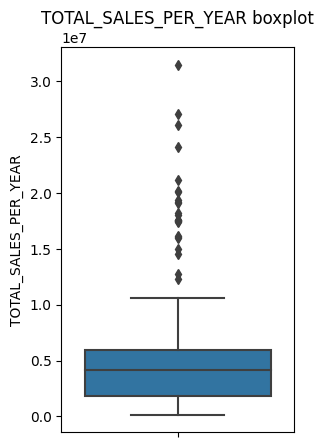

In [376]:
# plot box plot for 'minimum_nights' variable
plt.figure(figsize=(3,5))
sns.boxplot(y=final_df['TOTAL_SALES_PER_YEAR'])
plt.title('TOTAL_SALES_PER_YEAR boxplot')
plt.show()

Outliers for the target variable wold not dealt with even if observed as it would be considered cherry picking convenient data. Furthermore, due to the relatively small number of menu items, if subsetting of the target variable was done, there might be too limited data to build an accurate model.

# Train Test Split

In [377]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df.drop('TOTAL_SALES_PER_YEAR', axis=1), final_df['TOTAL_SALES_PER_YEAR'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((117, 4), (51, 4))

# Categorical Variable Encoding 

In [378]:
# let's create the encoder

ohe_enc = OneHotEncoder(
    top_categories=None,
    drop_last=True)  # to return k-1, false to return k

In [379]:
# fit the encoder to the train set: it will learn the variables and 
# categories to encode
ohe_enc.fit(X_train)

OneHotEncoder(drop_last=True)

In [380]:
X_train = ohe_enc.transform(X_train)
X_test = ohe_enc.transform(X_test)

# Scaling

## Min Max Scaler

In [381]:
# set up the scaler
scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [382]:
# Save the model to a file
joblib.dump(scaler, "StreamlitApp/assets/truck_min_max_scaler.joblib")

['StreamlitApp/assets/truck_min_max_scaler.joblib']

## Standard Scaler

In [383]:
# # set up the scaler
# scaler = StandardScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Standard Scaler did not lead to a difference in result.

In [384]:
# # set up the scaler
# scaler = RobustScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Robust Scaler did not lead to a difference in result.

In [385]:
# let's transform the returned NumPy arrays to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Build Models

## Linear Regression

In [386]:
# create the linear regression model
# fit the model to the training data
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [387]:
# Calculated the fitted values for training set
y_fitted = lm.predict(X_train)

# Task 5a: calculated the predicated value for testing data
y_pred = lm.predict(X_test)

In [388]:
model_performance(lm)

the training root mean squared error is:  1290231425.0314953
the testing root mean squared error is:  1290064011.8458033

the training mean squared error is:  1.664697130138803e+18
the testing mean squared error is:  1.664265154659689e+18

training accuracy is:  -47557.710450377366
testing accuracy is:  -42206.45040750081


## Decision Tree

In [389]:
# Create Decision Tree Regressor with random state equal to 2
# fit the model to the training data
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=2)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=2)

In [390]:
model_performance(tree_reg)

the training root mean squared error is:  7996898.489744338
the testing root mean squared error is:  7687132.2414846

the training mean squared error is:  63950385455275.27
the testing mean squared error is:  59092002098072.05

training accuracy is:  -0.8269977222846945
testing accuracy is:  -0.4986330399643024


## MLP Regressor

In [391]:
# Create the ann model
mlp = MLPRegressor(activation ='relu', hidden_layer_sizes=(10,), max_iter= 2000, solver = 'sgd', random_state=2)
# Fit the model to the training set
mlp.fit(X_train,y_train)

MLPRegressor(hidden_layer_sizes=(10,), max_iter=2000, random_state=2,
             solver='sgd')

In [392]:
model_performance(mlp)

the training root mean squared error is:  4413765234543.244
the testing root mean squared error is:  4413764288383.284

the training mean squared error is:  1.9481323545662575e+25
the testing mean squared error is:  1.94813151934076e+25

training accuracy is:  -556561676549.156
testing accuracy is:  -494065890038.4867


## ADA Boost Regressor

In [393]:
# Build Ada Boost Model 
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3), n_estimators = 20, learning_rate =0.1)
# fit the model to the training data
ada_reg.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3),
                  learning_rate=0.1, n_estimators=20)

In [394]:
model_performance(ada_reg)

the training root mean squared error is:  6647898.739203958
the testing root mean squared error is:  6570229.18784104

the training mean squared error is:  44194557646709.57
the testing mean squared error is:  43167911580758.33

training accuracy is:  -0.26259373705240874
testing accuracy is:  -0.09478197157399681


## SVR

In [395]:
svr = SVR(C=0.8, kernel ='rbf')
svr.fit(X_train, y_train)

SVR(C=0.8)

In [396]:
model_performance(svr)

the training root mean squared error is:  6086572.767193928
the testing root mean squared error is:  6297951.009890252

the training mean squared error is:  37046368050346.75
the testing mean squared error is:  39664186922977.64

training accuracy is:  -0.058377202342894785
testing accuracy is:  -0.005923964590695219


## XGBoost Regressor

In [397]:
# Build XGBoost Model
xgb = XGBRegressor(n_estimators = 20, learning_rate = 0.1, use_label_encoder = False, eval_metric='logloss')
# fit the model to the training data
xgb.fit(X_train_scaled, y_train)
model_performance(xgb)

the training root mean squared error is:  2255369.479510499
the testing root mean squared error is:  3641987.453192496

the training mean squared error is:  5086691489107.459
the testing mean squared error is:  13264072609211.564

training accuracy is:  0.8546783776453741
testing accuracy is:  0.6636096806525615


# Model Improvement (GridSearch CV)

In [398]:
param_grid = {'n_estimators': [10, 20, 30, 40],
              'learning_rate': [0.1, 0.2, 0.3, 0.4],
              'max_depth': [3,4,5,6,7,8]}

xgb_grid = GridSearchCV(xgb, param_grid, cv=5)
xgb_grid.fit(X_train_scaled, y_train)

best_params = xgb_grid.best_params_
print("Best parameters found: ", best_params)
print("Best score found: ", xgb_grid.best_score_)

Best parameters found:  {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 10}
Best score found:  0.6290224643594817


# Improved Model 

In [399]:
# Build XGBoost Model
xgb_improved = XGBRegressor(**best_params)
# fit the model to the training data
xgb_improved.fit(X_train_scaled, y_train)

model_performance(xgb_improved)

the training root mean squared error is:  2639914.9054087666
the testing root mean squared error is:  3066088.0258347974

the training mean squared error is:  6969150707799.376
the testing mean squared error is:  9400895782167.525

training accuracy is:  0.8008984249467427
testing accuracy is:  0.7615837588133274


In [400]:
# Save the model to a file
joblib.dump(xgb_improved, "StreamlitApp/assets/truck_xgb_improved.joblib")

['StreamlitApp/assets/truck_xgb_improved.joblib']

In [401]:
xgb_improved.feature_importances_

array([0.91651326, 0.03331277, 0.02900281, 0.02117116, 0.        ,
       0.        , 0.        ], dtype=float32)

In [402]:
# Get the feature importances
feature_importance = xgb_improved.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

                      Feature  Importance
0                    TRUCK_ID    0.916513
1                MENU_TYPE_ID    0.033313
2                        YEAR    0.029003
3         PRIMARY_CITY_Denver    0.021171
4      PRIMARY_CITY_San Mateo    0.000000
5         PRIMARY_CITY_Boston    0.000000
6  PRIMARY_CITY_New York City    0.000000


In [403]:
X_train.head()

,TRUCK_ID,MENU_TYPE_ID,YEAR,PRIMARY_CITY_Denver,PRIMARY_CITY_San Mateo,PRIMARY_CITY_Boston,PRIMARY_CITY_New York City
121,29,14,2022,1,0,0,0
104,12,12,2022,0,1,0,0
109,17,2,2022,1,0,0,0
27,60,15,2020,0,0,1,0
90,73,13,2021,0,0,0,1


In [404]:
X_train.columns

Index(['TRUCK_ID', 'MENU_TYPE_ID', 'YEAR', 'PRIMARY_CITY_Denver',
       'PRIMARY_CITY_San Mateo', 'PRIMARY_CITY_Boston',
       'PRIMARY_CITY_New York City'],
      dtype='object')